# Trabajo Práctico 1

## Simulación 75.26 / 95.19

## Grupo: 4

## Generador de números pseudoaleatorios: LXM

### Integrantes del grupo:

* Gestoso, Ramiro
    * Padrón 105950
* Brizuela Lopez, Mariano
    * Padrón 105079
* Markarian, Darío Hernan
    * Padrón 98684
* Ripetour, Diego
    * Padrón 86601

### Imports

In [53]:
from numpy import uint64
import numpy as np
from math import exp, factorial
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Implementación del generador asignado LXM

## Definicion de Generador LXM

Permite generar una cantidad N de numeros:
* uniformes (nextRand)
* normales con media y desvío cualesquiera (generate_normal)
* exponenciales (generate_exponential)

In [54]:
N_BITS = uint64(64)
def rotateLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return (n << d)|(n >> (N_BITS - d))

def shiftLeft(n, d):
    n = uint64(n)
    d = uint64(d)
    return n << d

def shiftRight(n, d):
    n = uint64(n)
    d = uint64(d)
    return n >> d

class LXM:

    M = uint64(0xd1342543de82ef95)
    a = uint64(13)
    s = uint64(0)
    x0 = uint64(11)
    x1 = uint64(57)
    c = uint64(0xdaba0b6eb09322e3)
    
    def __init__(self, seed=11):
        self.x0 = uint64(seed)
        if self.x0 == self.x1:
            self.x1 += 1
    
    def nextRand(self, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")

        numbers = []
        for i in range(n):
            # Combining operation
            z = self.s + self.x0
            # Mixing function (lea64)
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32))) * self.c
            z = (z ^ (shiftRight(z, 32)))
            # Update the LCG subgenerator
            self.s = self.M * self.s + self.a
            # Update the XBG subgenerator (xoroshiro128v1_0)
            q0, q1 = self.x0, self.x1
            q1 ^= q0
            q0 = rotateLeft(q0, 24)
            q1 = q0 ^ q1 ^ (shiftLeft(q1, 24))
            q1 = rotateLeft(q1, 37)
            self.x0, self.x1 = q0, q1
            #result
            numbers.append(z / uint64(-1))
            
        return numbers[0] if n==1 else np.array(numbers)

    def generate_normal(self, mean, deviation, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")
        U1 = self.nextRand(n)
        U2 = self.nextRand(n)
        R = np.sqrt(-2* np.log(U1))
        Theta = 2 * np.pi * U2
        #normal_1 = R * np.cos(Theta)
        normal = R * np.sin(Theta)
        return deviation*normal + mean
    
    def generate_exponential(self, param, n=1):
        if n < 1:
            raise Exception("'n' must be 1 or greater")
        if param < 0:
            raise Exception("the exponential parameter must be greater than 0")
        U = self.nextRand(n)
        return (-1/param)*np.log(1-U)
        

### Instanciamos el generador

In [55]:
gen = LXM(31)

## Graficamos los numeros generados

### Generación numeros con distribución uniforme en el intervalo 0 - 1

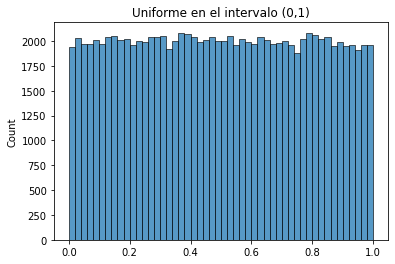

In [56]:
arr = gen.nextRand(100_000)
sns.histplot(bins=50, x=arr)
plt.title("Uniforme en el intervalo (0,1)")
plt.show()

### Generación de uniforme en el intervalo a - b

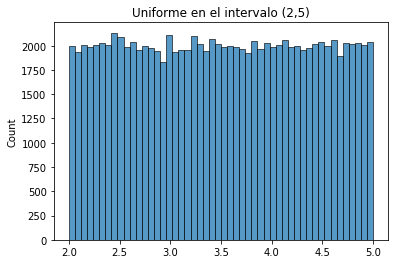

In [57]:
a = 2
b = 5
nums = gen.nextRand(100_000)
nums = nums * (b-a) + a

sns.histplot(bins=50, x=nums)
plt.title("Uniforme en el intervalo (2,5)")
plt.show()

### Generacion de Normal Estandar con 2 uniformes - Metodo de Box Muller

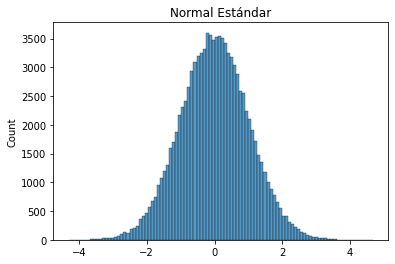

In [58]:
sns.histplot(bins=100, x=gen.generate_normal(0, 1, 100_000))
plt.title("Normal Estándar")
plt.show()

### Generar la variable aleatoria Normal con esperanza E y desvio D

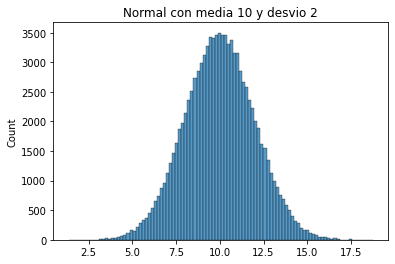

In [59]:
normal2 = gen.generate_normal(10, 2, 100_000)
sns.histplot(bins=100, x=normal2)
plt.title("Normal con media 10 y desvio 2")
plt.show()

In [60]:
# Verificamos
esp = round(normal2.mean(), 2)
desv = round(normal2.std(), 2)
print(f'Normal(10,2)\nEsperanza = {esp}\nDesvio = {desv}')

Normal(10,2)
Esperanza = 9.99
Desvio = 2.0


### Generación de Exponencial con parámetro 1

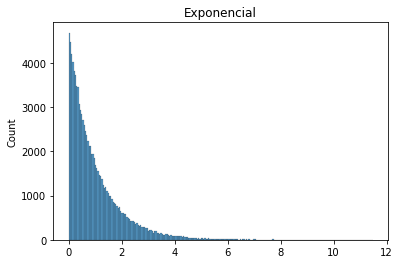

In [61]:
exp = gen.generate_exponential(1, 100_000)
sns.histplot(exp)
plt.title('Exponencial')
plt.show()

## Test de uniformidad - Chi 2
* H0: La muestra sigue una distribucion uniforme
* H1: La muestra no sigue una distribucio uniforme

Vemos si podemos rechazar (o no) H0.

In [73]:
from scipy.stats import chi2

bins=50

frecuencias = np.histogram(arr,bins=bins,density=False)[0]    

cantidad = len(arr)

limiteSuperior = chi2.ppf(0.95, df=bins-1)

Ei=cantidad/bins
    
D2 = sum([(Oi - Ei)**2 for Oi in frecuencias])/Ei

if D2 <= limiteSuperior:
    print("El test acepta la hipotesis nula.")
else:
    print("El test rechaza la hipótesis nula")

El test acepta la hipotesis nula.


## Test de uniformidad - Kolmogorov Smirnov
* H0: La muestra sigue una distribucion uniforme
* H1: La muestra no sigue una distribucio uniforme

Vemos si podemos rechazar (o no) H0.

In [63]:
for n in [10, 10_000, 100_000]:
    data = gen.nextRand(n)
    kstest_test = stats.kstest(data, 'uniform')
    if kstest_test.pvalue > 0.05:
        print('Datos uniformes (No se puede rechazar H0)')
    else:
        print('Datos no uniformes (Se rechaza H0)')

Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)
Datos uniformes (No se puede rechazar H0)


## Test de normalidad - Anderson-Darling

* H0: La muestra sigue una distribucion normal
* H1: La muestra no sigue una distribucio normal

Vemos si podemos rechazar (o no) H0.

In [11]:
for n in [10, 10_000, 50_000]:
    print(f"\nTest n = {n}")
    data = gen.generate_normal(2, 10, n)
    #Ejecutamos el test de normalidad (por defecto compara contra Normal)
    resultado = stats.anderson(data)
    print('Estadístico: %.3f' % resultado.statistic)
    for i in range(len(resultado.critical_values)):
        nivel_significancia, umbral = resultado.significance_level[i]/100, resultado.critical_values[i]
        if resultado.statistic < resultado.critical_values[i]:
            print('%.3f: %.3f, Datos normales (No se puede rechazar H0)' % (nivel_significancia, umbral))
        else:
            print('%.3f: %.3f, Datos No normales (Se rechaza H0)' % (nivel_significancia, umbral))


Test n = 10
Estadístico: 0.252
0.150: 0.501, Datos normales (No se puede rechazar H0)
0.100: 0.570, Datos normales (No se puede rechazar H0)
0.050: 0.684, Datos normales (No se puede rechazar H0)
0.025: 0.798, Datos normales (No se puede rechazar H0)
0.010: 0.950, Datos normales (No se puede rechazar H0)

Test n = 10000
Estadístico: 0.277
0.150: 0.576, Datos normales (No se puede rechazar H0)
0.100: 0.656, Datos normales (No se puede rechazar H0)
0.050: 0.787, Datos normales (No se puede rechazar H0)
0.025: 0.918, Datos normales (No se puede rechazar H0)
0.010: 1.092, Datos normales (No se puede rechazar H0)

Test n = 50000
Estadístico: 0.369
0.150: 0.576, Datos normales (No se puede rechazar H0)
0.100: 0.656, Datos normales (No se puede rechazar H0)
0.050: 0.787, Datos normales (No se puede rechazar H0)
0.025: 0.918, Datos normales (No se puede rechazar H0)
0.010: 1.092, Datos normales (No se puede rechazar H0)


### Test de normalidad - Saphiro

In [12]:
for n in [10, 10_000, 100_000]:
    data = gen.generate_normal(2, 10, n)
    shapiro_test = stats.shapiro(data)
    if shapiro_test.pvalue > 0.05:
        print('Datos normales (No se puede rechazar H0)')
    else:
        print('Datos no normales (Se rechaza H0)')

Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)
Datos normales (No se puede rechazar H0)


# Proceso de Poisson

## Cargamos el archivo txt

In [13]:
tiempos_entre_arribos = np.loadtxt('tiempos_entre_arribos.txt')

## Graficamos la distribución de los datos
Los tiempos entre arribos deberian estar distribuidos como una exponencial.

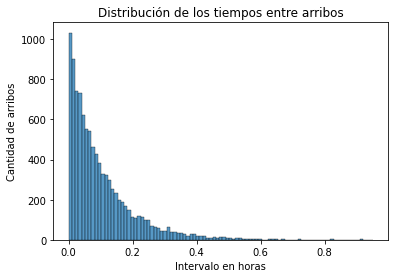

In [14]:
sns.histplot(tiempos_entre_arribos)
plt.title('Distribución de los tiempos entre arribos')
plt.xlabel('Intervalo en horas')
plt.ylabel('Cantidad de arribos')
plt.show()

Si hacemos la suma acumulativa, obtenemos todos los eventos de un proceso de Poisson.

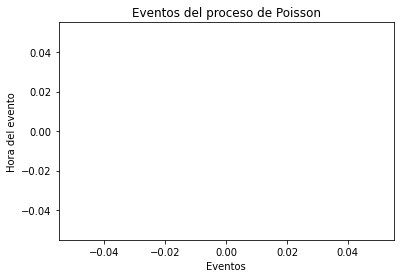

In [15]:
eventos_proceso = tiempos_entre_arribos.cumsum()
sns.scatterplot(eventos_proceso, s=5, marker='x')
plt.title('Eventos del proceso de Poisson')
plt.xlabel('Eventos')
plt.ylabel('Hora del evento')
plt.show()

### Estimamos el valor de la tasa de arribos mediante la distribución de intervalo de tiempo entre arribos

Estimamos la tasa de arribos $\lambda$ como el parametro de las exponenciales (tiempo entre arribos). Calculamos la media de las exponenciales y $\lambda$ será $\frac{1}{media}$

In [16]:
lam = round(1/tiempos_entre_arribos.mean(), 2)
print(f'El parametro lambda es {lam} arribos de vehiculos por hora')

El parametro lambda es 9.89 arribos de vehiculos por hora


## Realizamos un test sobre los tiempos entre arribos para confirmar que provienen de una distribucion exponencial y por lo tanto tratamos con un proceso de Poisson

Realizamos un Test de Kolmogorov Smirnov
* H0: La muestra sigue una distribucion exponencial
* H1: La muestra no sigue una distribucio exponencial

Vemos si podemos rechazar (o no) H0.

In [17]:
# Se repite varias veces el test
for i in range(5):
    # creo muestra exponencial con mismos parametros que nuestros datos
    exp = stats.expon.rvs(scale=1/lam, size=len(tiempos_entre_arribos))
    
    kstest_test = stats.kstest(tiempos_entre_arribos, exp)
    
    if kstest_test.pvalue > 0.05:
        print('Datos exponenciales (No se puede rechazar H0)')
    else:
        print('Datos no exponenciales (Se rechaza H0)')

Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)
Datos exponenciales (No se puede rechazar H0)


## Simulación de llegada de vehiculos durante un mes

### Definimos un generador de procesos de Poisson usando el generador LXM

In [18]:
def run_poisson_process(generator, lamb, tmax):
    # Guaramos el tiempo de los arribos que van llegando
    t=[]
    
    # Partinmos desde t0=0
    arribo = 0
    
    arribo += generator.generate_exponential(lamb)
    while (arribo <= tmax):
        # Se agrega a la lista
        t.append(arribo)
        # Se genera un nuevo arribo
        z = generator.generate_exponential(lamb)
        # Se suma al arribo anterior
        arribo = arribo + z
       
    return t

### Realizamos la simulación

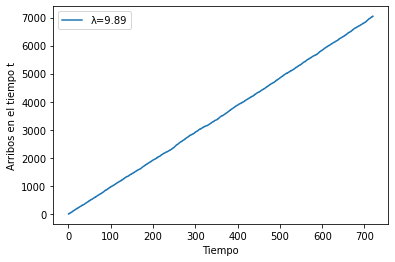

In [19]:
# Parametro de la exponencial (9.89 en horas)
lamb = 9.89

# definimos un mes
tmax = 30*24 #(HORAS)

# Corro el proceso
t = run_poisson_process(LXM(19), lamb, tmax)
    
plt.step(t,range(len(t)),where= 'post' ,label=f'λ={lamb}')
plt.xlabel('Tiempo')
plt.ylabel('Arribos en el tiempo t')
plt.legend()
plt.show()

## Estimamos distintas probabilidades a partir de simulaciones

In [20]:
# Seteamos parametros a usar
generator = LXM(19)
n = 1000 # repeticiones del proceso
lamb = 9.89 # parametro de arribo de vehiculos por hora

### Probabilidad que el primer vehículo arribe antes de los 10 minutos

Se interpreta como que, dentro de del intervalo de tiempo de 10 minutos, al menos un vehículo arribe.

$ \lambda = 9.89 \cdot \frac{vechiculos}{hora} $

$ N(t)\sim Poisson(\lambda t) $

$ P(N(\frac{1}{6})\geq 1)=1 - P(N(\frac{1}{6})< 1)=1 - P(N(\frac{1}{6})=0)=1 - \frac{(9.89\cdot \frac{1}{6})^0}{0!}\cdot e^{-9.89\cdot \frac{1}{6}}=1-e^{-9.89\cdot \frac{1}{6}} \approx 0.81$ 

In [21]:
# tiempo maximo
tmax = 10/60 #(HORAS)

# casos favorables
favorables = 0

# se corre 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(generator, lamb, tmax)
    
    cant_arribos = len(t)
    if cant_arribos >= 1:
        favorables += 1

P = favorables / n

print(f'Probabilidad resultado de la simulación: {round(P,2)}')

Probabilidad resultado de la simulación: 0.79


### Probabilidad que el undécimo vehículo arribe después de los 60 minutos

Para este caso tenemos dos interpretaciones del mismo problema, que llevan al mismo resultado:

1. Calcular que el tiempo de llegada del onceavo vehículo sea despues de los 60 minutos

2. Calcular la probabilidad de que en 60 minutos no lleguen mas de 10 vehiculos

Para este caso, optamos por la opcion 2.

$ \lambda = 9.89 \cdot \frac{vechiculos}{hora}$

$ N(t)\sim Poisson(\lambda t) $

$P(N(1)\leq10)=\sum_{n=0}^{10}\frac{(9.89\cdot 1)^n}{n!}\cdot e^{-9.89\cdot 1} \approx 0.60$

In [22]:
# tiempo maximo
tmax = 1 #(HORAS)

# casos favorables
favorables = 0

# se corre 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(generator, lamb, tmax)
    
    cant_arribos = len(t)
    if cant_arribos <= 10:
        favorables += 1

P = favorables / n

print(f'Probabilidad resultado de la simulación: {round(P,2)}')

Probabilidad resultado de la simulación: 0.63


### Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

Se interpreta como que, dentro de las primeras 72 horas, arriben al menos 750 vehículos.

$ \lambda = 9.89 \cdot \frac{vechiculos}{hora} $

$ N(t)\sim Poisson(\lambda t) $

$ P(N(72)\geq 750)=1 - P(N(72)< 750)=1 - \sum_{n=0}^{749}\frac{(9.89\cdot 72)^n}{n!}\cdot e^{-9.89\cdot 72}\approx 0.08 $ 

In [23]:
# tiempo maximo
tmax = 72 #(HORAS)

# casos favorables
favorables = 0

# se corre 1000 veces el experimento
for i in range (0,n):
    t = run_poisson_process(generator, lamb, tmax)
    
    cant_arribos = len(t)
    if cant_arribos >= 750:
        favorables += 1 

P = favorables / n

print(f'Probabilidad resultado de la simulación: {round(P,2)}')

Probabilidad resultado de la simulación: 0.07
